In [1]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
from importlib import reload
import warnings
from pprint import pprint
import string
import pyLDAvis.gensim as gensimvis
import pickle 
import pyLDAvis
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
STOPWORDS.update(["a","will","el","del","lo", "abord", "absolument", "afin", "ah", "ai", "aie", "aient", "aies", "ailleurs", "ainsi", "ait", "allaient", "allo",
 "allons", "allô", "alors", "anterieur", "anterieure", "anterieures", "apres", "après", "as", "assez", "attendu", "au",
 "aucun", "aucune", "aucuns", "aujourd", "aujourd'hui", "aupres", "auquel", "aura", "aurai", "auraient", "aurais",
 "aurait", "auras", "aurez", "auriez", "aurions", "aurons", "auront", "aussi", "autant", "autre", "autrefois",
 "autrement", "autres", "autrui", "aux", "auxquelles", "auxquels", "avaient", "avais", "avait", "avant", "avec", "avez",
 "aviez", "avions", "avoir", "avons", "ayant", "ayez", "ayons", "b", "bah", "bas", "basee", "bat", "beau", "beaucoup",
 "bien", "bigre", "bon", "boum", "bravo", "brrr", "c", "car", "ce", "ceci", "cela", "celle", "celle-ci", "celle-là",
 "celles", "celles-ci", "celles-là", "celui", "celui-ci", "celui-là", "celà", "cent", "cependant", "certain",
 "certaine", "certaines", "certains", "certes", "ces", "cet", "cette", "ceux", "ceux-ci", "ceux-là", "chacun",
 "chacune", "chaque", "cher", "chers", "chez", "chiche", "chut", "chère", "chères", "ci", "cinq", "cinquantaine",
 "cinquante", "cinquantième", "cinquième", "clac", "clic", "combien", "comme", "comment", "comparable", "comparables",
 "compris", "concernant", "contre", "couic", "crac", "d", "da", "dans", "de", "debout", "dedans", "dehors", "deja",
 "delà", "depuis", "dernier", "derniere", "derriere", "derrière", "des", "desormais", "desquelles", "desquels",
 "dessous", "dessus", "deux", "deuxième", "deuxièmement", "devant", "devers", "devra", "devrait", "different",
 "differentes", "differents", "différent", "différente", "différentes", "différents", "dire", "directe", "directement",
 "dit", "dite", "dits", "divers", "diverse", "diverses", "dix", "dix-huit", "dix-neuf", "dix-sept", "dixième", "doit",
 "doivent", "donc", "dont", "dos", "douze", "douzième", "dring", "droite", "du", "duquel", "durant", "dès", "début",
 "désormais", "e", "effet", "egale", "egalement", "egales", "eh", "elle", "elle-même", "elles", "elles-mêmes", "en",
 "encore", "enfin", "entre", "envers", "environ", "es", "essai", "est", "et", "etant", "etc", "etre", "eu", "eue",
 "eues", "euh", "eurent", "eus", "eusse", "eussent", "eusses", "eussiez", "eussions", "eut", "eux", "eux-mêmes",
 "exactement", "excepté", "extenso", "exterieur", "eûmes", "eût", "eûtes", "f", "fais", "faisaient", "faisant", "fait",
 "faites", "façon", "feront", "fi", "flac", "floc", "fois", "font", "force", "furent", "fus", "fusse", "fussent",
 "fusses", "fussiez", "fussions", "fut", "fûmes", "fût", "fûtes", "g", "gens", "h", "ha", "haut", "hein", "hem", "hep",
 "hi", "ho", "holà", "hop", "hormis", "hors", "hou", "houp", "hue", "hui", "huit", "huitième", "hum", "hurrah", "hé",
 "hélas", "i", "ici", "il", "ils", "importe", "j", "je", "jusqu", "jusque", "juste", "k", "l", "la", "laisser",
 "laquelle", "las", "le", "lequel", "les", "lesquelles", "lesquels", "leur", "leurs", "longtemps", "lors", "lorsque",
 "lui", "lui-meme", "lui-même", "là", "lès", "m", "ma", "maint", "maintenant", "mais", "malgre", "malgré", "maximale",
 "me", "meme", "memes", "merci", "mes", "mien", "mienne", "miennes", "miens", "mille", "mince", "mine", "minimale",
 "moi", "moi-meme", "moi-même", "moindres", "moins", "mon", "mot", "moyennant", "multiple", "multiples", "même",
 "mêmes", "n", "na", "naturel", "naturelle", "naturelles", "ne", "neanmoins", "necessaire", "necessairement", "neuf",
 "neuvième", "ni", "nombreuses", "nombreux", "nommés", "non", "nos", "notamment", "notre", "nous", "nous-mêmes",
 "nouveau", "nouveaux", "nul", "néanmoins", "nôtre", "nôtres", "o", "oh", "ohé", "ollé", "olé", "on", "ont", "onze",
 "onzième", "ore", "ou", "ouf", "ouias", "oust", "ouste", "outre", "ouvert", "ouverte", "ouverts", "o|", "où", "p",
 "paf", "pan", "par", "parce", "parfois", "parle", "parlent", "parler", "parmi", "parole", "parseme", "partant",
 "particulier", "particulière", "particulièrement", "pas", "passé", "pendant", "pense", "permet", "personne",
 "personnes", "peu", "peut", "peuvent", "peux", "pff", "pfft", "pfut", "pif", "pire", "pièce", "plein", "plouf",
 "plupart", "plus", "plusieurs", "plutôt", "possessif", "possessifs", "possible", "possibles", "pouah", "pour",
 "pourquoi", "pourrais", "pourrait", "pouvait", "prealable", "precisement", "premier", "première", "premièrement",
 "pres", "probable", "probante", "procedant", "proche", "près", "psitt", "pu", "puis", "puisque", "pur", "pure", "q",
 "qu", "quand", "quant", "quant-à-soi", "quanta", "quarante", "quatorze", "quatre", "quatre-vingt", "quatrième",
 "quatrièmement", "que", "quel", "quelconque", "quelle", "quelles", "quelqu'un", "quelque", "quelques", "quels", "qui",
 "quiconque", "quinze", "quoi", "quoique", "r", "rare", "rarement", "rares", "relative", "relativement", "remarquable",
 "rend", "rendre", "restant", "reste", "restent", "restrictif", "retour", "revoici", "revoilà", "rien", "s", "sa",
 "sacrebleu", "sait", "sans", "sapristi", "sauf", "se", "sein", "seize", "selon", "semblable", "semblaient", "semble",
 "semblent", "sent", "sept", "septième", "sera", "serai", "seraient", "serais", "serait", "seras", "serez", "seriez",
 "serions", "serons", "seront", "ses", "seul", "seule", "seulement", "si", "sien", "sienne", "siennes", "siens",
 "sinon", "six", "sixième", "soi", "soi-même", "soient", "sois", "soit", "soixante", "sommes", "son", "sont", "sous",
 "souvent", "soyez", "soyons", "specifique", "specifiques", "speculatif", "stop", "strictement", "subtiles",
 "suffisant", "suffisante", "suffit", "suis", "suit", "suivant", "suivante", "suivantes", "suivants", "suivre", "sujet",
 "superpose", "sur", "surtout", "t", "ta", "tac", "tandis", "tant", "tardive", "te", "tel", "telle", "tellement",
 "telles", "tels", "tenant", "tend", "tenir", "tente", "tes", "tic", "tien", "tienne", "tiennes", "tiens", "toc", "toi",
 "toi-même", "ton", "touchant", "toujours", "tous", "tout", "toute", "toutefois", "toutes", "treize", "trente", "tres",
 "trois", "troisième", "troisièmement", "trop", "très", "tsoin", "tsouin", "tu", "té", "u", "un", "une", "unes",
 "uniformement", "unique", "uniques", "uns", "v", "va", "vais", "valeur", "vas", "vers", "via", "vif", "vifs", "vingt",
 "vivat", "vive", "vives", "vlan", "voici", "voie", "voient", "voilà", "voire", "vont", "vos", "votre", "vous",
 "vous-mêmes", "vu", "vé", "vôtre", "vôtres", "w", "x", "y", "z", "zut", "à", "â", "ça", "ès", "étaient", "étais",
 "était", "étant", "état", "étiez", "étions", "été", "étée", "étées", "étés", "êtes", "être", "ô"])

In [3]:
warnings.filterwarnings("ignore")

In [4]:
import clean_tweets_dataframe as cld

In [5]:
reload(cld)

<module 'clean_tweets_dataframe' from 'C:\\Users\\Faith Bagire\\PycharmProjects\\pythonProject\\tweets_analyze\\clean_tweets_dataframe.py'>

In [6]:
df_tweet=pd.read_excel("week2_new.xlsx",engine='openpyxl',dtype={'tweet_id':'str'})

In [7]:
cleaner=cld.CleanTweets(df_tweet)

Automation in Action...!!!


**Using cleaner module from clean_tweets_dataframe to clean the imported dataset**

In [8]:
df_tweet.shape

(16635, 22)

In [9]:
df_tweet.dropna(subset=['cleaned_text'],inplace=True)

In [10]:
df_tweet=cleaner.drop_unwanted_column(df_tweet)

In [11]:
df_tweet=cleaner.convert_to_datetime(df_tweet)
df_tweet=cleaner.convert_to_numbers(df_tweet)
df_tweet=cleaner.treat_special_characters(df_tweet)

In [12]:
df_tweet=cleaner.remove_other_languages_tweets(df_tweet)

In [13]:
df_tweet=cleaner.drop_retweets(df_tweet)

In [14]:
print(df_tweet.shape)
df_tweet

(8678, 22)


,created_at,source,original_text,cleaned_text,polarity,subjectivity,sentiment,lang,likes_count,reply_count,...,followers_count,friends_count,possibly_sensitive,hashtags,retweet_hashtags,user_mentions,place,tweet_url,tweet_id,tweet_category
0,2022-07-31 12:24:57+00:00,Twitter for Android,RT @CryptoTownEU: 🚀 Airdrop: ReadFi\n💰 Value: ...,🚀 Airdrop: ReadFi\n💰 Value: 20 $RDF ($1.2)\n👥 ...,0.000000,0.00,Neutral,en,0,0,...,252,2493,False,NaN,"Airdrop, Airdrops, Crypto",CryptoTownEU,"dacca, bangladesh",https://twitter.com/Tusar03738675/status/15537...,1553718354913140736,Retweet
2,2022-07-31 12:23:57+00:00,Twitter Web App,RT @CryptoTownEU: 🚀 Airdrop: ReadFi\n💰 Value: ...,🚀 Airdrop: ReadFi\n💰 Value: 20 $RDF ($1.2)\n👥 ...,0.000000,0.00,Neutral,en,0,0,...,124,1592,False,NaN,"Airdrop, Airdrops, Crypto",CryptoTownEU,NaN,https://twitter.com/FaiqMadani/status/15537181...,1553718105834389510,Retweet
3,2022-07-31 12:23:55+00:00,Twitter for iPhone,-The Best Opportunity To Earn Crypto Via Readi...,-The Best Opportunity To Earn Crypto Via Readi...,0.683333,0.45,Positive,en,0,0,...,6,286,False,NaN,NaN,NaN,NaN,https://twitter.com/RAjusiagram/status/1553718...,1553718097760071681,Tweet
4,2022-07-31 12:23:17+00:00,Twitter for Android,-The Best Opportunity To Earn Crypto Via Readi...,-The Best Opportunity To Earn Crypto Via Readi...,0.683333,0.45,Positive,en,0,0,...,88,2213,False,NaN,NaN,NaN,NaN,https://twitter.com/pacarnyaanya69/status/1553...,1553717936384544769,Tweet
5,2022-07-31 12:23:14+00:00,Twitter Web App,RT @CryptoTownEU: 🚀 Airdrop: ReadFi\n💰 Value: ...,🚀 Airdrop: ReadFi\n💰 Value: 20 $RDF ($1.2)\n👥 ...,0.000000,0.00,Neutral,en,0,0,...,2,40,False,NaN,"Airdrop, Airdrops, Crypto",CryptoTownEU,NaN,https://twitter.com/DariushHaji11/status/15537...,1553717922316668928,Retweet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,2022-07-24 13:26:15+00:00,Twitter for Android,"RT @RwandaMoD: Today, Benin Armed Forces Chief...","Today, Benin Armed Forces Chief of Army Staff,...",0.050000,0.50,Positive,en,0,0,...,144,88,False,NaN,NaN,RwandaMoD,Rwanda,https://twitter.com/Eva_Official___/status/155...,1551197068177412096,Retweet
16603,2022-07-24 13:02:14+00:00,EUwatch,Macron says Iran nuclear deal remains possible...,Macron says Iran nuclear deal remains possible...,0.000000,1.00,Neutral,en,0,0,...,25713,7631,False,NaN,NaN,NaN,brussels,https://twitter.com/EUwatchers/status/15511910...,1551191023208079361,Tweet
16619,2022-07-24 12:41:55+00:00,Twitter Web App,RT @EUwatchers: Russia-Ukraine updates: Russia...,Russia-Ukraine updates: Russia says it hit mil...,-0.100000,0.10,Negative,en,0,0,...,1752,4352,False,NaN,NaN,EUwatchers,canada,https://twitter.com/mig30m6/status/15511859098...,1551185909802061824,Retweet
16629,2022-07-24 12:31:56+00:00,EUwatch,Macron says Iran nuclear deal 'still possible'...,Macron says Iran nuclear deal 'still possible'...,0.000000,1.00,Neutral,en,0,0,...,25713,7631,False,NaN,NaN,NaN,brussels,https://twitter.com/EUwatchers/status/15511833...,1551183398491852801,Tweet


In [15]:
df_tweet = df_tweet[df_tweet.original_author != 'dwnews']
df_tweet = df_tweet[df_tweet.original_author != '123_INFO_DE']
df_tweet = df_tweet[df_tweet.original_author != 'rogue_corq']
df_tweet = df_tweet[df_tweet.original_author != 'Noticieros_MEX']
df_tweet = df_tweet[df_tweet.original_author != 'EUwatchers']

In [16]:
# drop crypo bots 
df_tweet=df_tweet[~pd.Series(df_tweet['cleaned_text']).str.contains("The Best Opportunity To Earn Crypto Via Reading")]

In [17]:
df_tweet.reset_index(drop=True,inplace=True)

In [18]:
df_tweet['lang'].value_counts()

en      5624
fr       408
kiny      60
Name: lang, dtype: int64

###  Export french tweets, make translation and insert back new translated tweets

In [19]:
df_trans=df_tweet.query("lang=='fr'| lang =='kiny'")[['original_text','cleaned_text','lang']]

### Translation with Google Sheet

In [20]:
import pygsheets

In [21]:
gc = pygsheets.authorize(service_file='tweet-auto-01-833e318c05c8.json')

In [22]:
sheet = gc.open('make_trans')[0]

In [23]:
sheet.set_dataframe(df_trans,start='A1',copy_index=True)

In [24]:
sheet.update_value('E1','translation')

In [25]:
# Browse the doc and make translations manually
print(sheet.url)

https://docs.google.com/spreadsheets/d/1ITYeneA29Vvk_wKESJh5J92reOKcyjDQNo_yitMXPGc/edit#gid=0


#### loop to translate, slow

In [26]:
# for i in range(2,len(df_trans)+2):
#     sheet.update_value('E'+str(i),'=GOOGLETRANSLATE(C'+str(i)+')')

In [27]:
dict_to_translate=df_tweet.query("lang=='fr'| lang =='kiny'")['cleaned_text'].to_dict()
dict_translated=sheet.get_as_df(index_column=1)[['translation']].to_dict()['translation']

In [29]:
# dict_translated

In [30]:
for idx in dict_to_translate.keys():
    df_tweet.loc[idx, 'cleaned_text'] = dict_translated[idx]

In [31]:
from textblob import TextBlob
from cleantext import clean

In [32]:
for idx in dict_translated.keys():
    blob = TextBlob(clean(dict_translated[idx], no_emoji=True))
    pol = blob.sentiment.polarity
    df_tweet.loc[idx, 'sentiment'] = 'Positive' if pol > 0 else (
        'Negative' if pol < 0 else 'Neutral')

#### Save new dataframe for dashboard creation

In [33]:
df_tweet['created_at'] = df_tweet['created_at'].apply(lambda x: x.replace(tzinfo=None))

In [34]:
df_tweet.to_excel('plotly_dashboard/week2_processed.xlsx')

**Now we continue with Tweet and Replies Only! Excluding Retweets**

In [35]:
df_tweet=df_tweet.query("tweet_category=='Tweet' or tweet_category== 'Reply'")

### EDA of Tweets

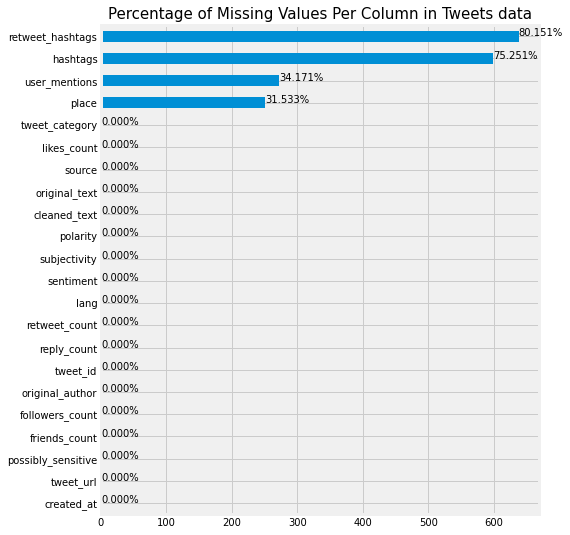

In [36]:
# Check the percentage of missing values in every column
ax = df_tweet.isna().sum().sort_values().plot(kind = 'barh', figsize = (7, 9))
plt.title('Percentage of Missing Values Per Column in Tweets data', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.3f}%'.format((p.get_width()/df_tweet.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

<AxesSubplot:ylabel='Place'>

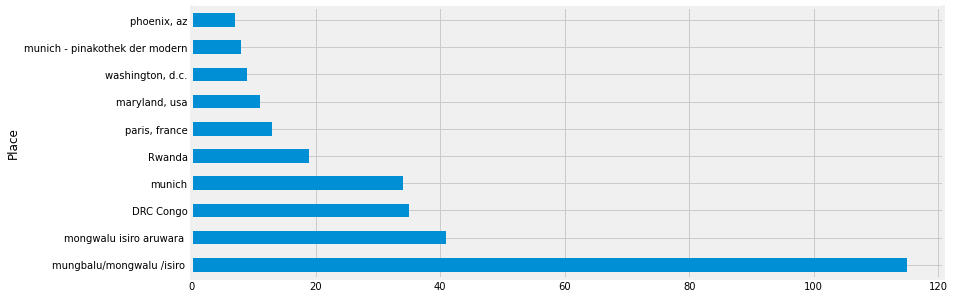

In [37]:
df_tweet['place'].value_counts(sort=True, ascending=False)[:10].plot(kind='barh',
                                                                     figsize=(12,5),xlabel='Place')

In [38]:
df_tweet_date=df_tweet.set_index('created_at')

<AxesSubplot:xlabel='Date,time'>

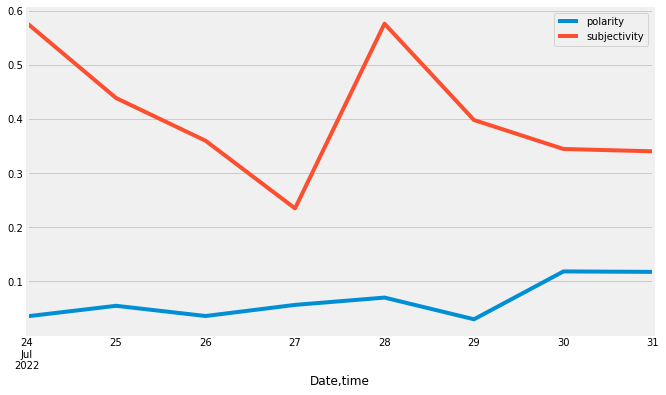

In [39]:
df_tweet_date.resample('D').mean()[['polarity','subjectivity']].dropna().plot(figsize=(10,6),xlabel='Date,time')

### uni-variate Analysis on Hashtags


In [40]:
hashtag_df=df_tweet[['original_text','hashtags','retweet_hashtags']]

In [41]:
df_tweet['original_text']=df_tweet['original_text'].astype('str')

In [42]:
def find_hashtags(df_tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', df_tweet)

In [44]:
hashtag_df['hashtag_check']=df_tweet.original_text.apply(find_hashtags)

In [45]:
hashtag_df.dropna(subset=['hashtag_check'],inplace=True)

In [46]:
tags_list=list(hashtag_df['hashtag_check'])

In [47]:
hashtags_list_df = pd.DataFrame([tag for tags_row in tags_list for tag in tags_row],columns=['hashtag'])

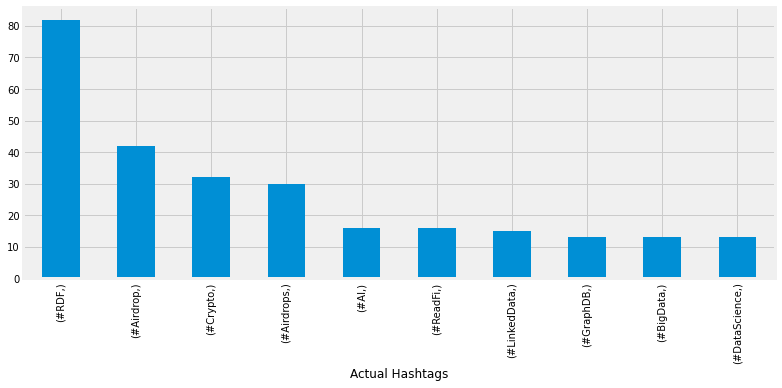

In [48]:
_=hashtags_list_df.value_counts()[:10].plot(kind='bar',figsize=(12,5),xlabel='Actual Hashtags')

In [49]:
#Convert hastags to lowercase
hashtags_list_df['hashtag'] = hashtags_list_df['hashtag'].str.lower()

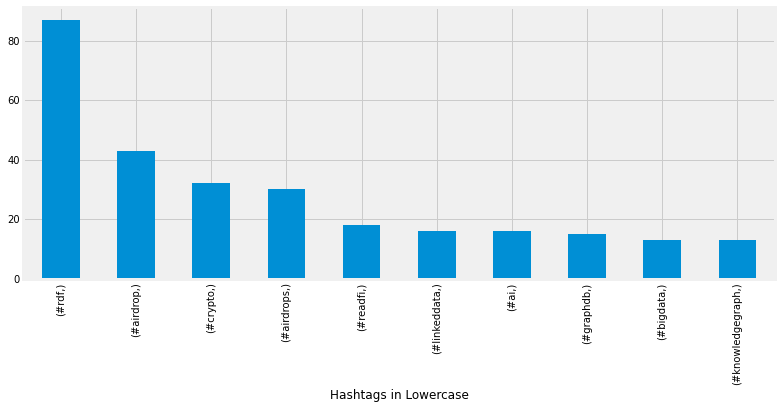

In [50]:
_=hashtags_list_df.value_counts()[:10].plot(kind='bar',figsize=(12,5),xlabel='Hashtags in Lowercase')

In [51]:
user_summary=df_tweet.groupby('original_author').agg({'cleaned_text':'count','followers_count':'max',
                                         'polarity':'mean','subjectivity':'mean', 'sentiment':pd.Series.mode})

In [52]:
user_summary.sort_values(by='cleaned_text',ascending=False).head(10)

,cleaned_text,followers_count,polarity,subjectivity,sentiment
original_author,,,,,
JustinM43619550,115,587.0,-0.003768,0.962754,Neutral
BlaazMASTAKI,41,265.0,0.000000,0.991870,Neutral
NetInthe,34,12.0,0.014622,0.139347,Neutral
SMARFreedom,17,2392.0,-0.113235,0.281863,Neutral
bouche_bee,13,2847.0,-0.030769,0.038462,Positive
acute_tomato,12,17509.0,-0.029003,0.142492,Neutral
KirkDBorne,11,343108.0,0.072727,0.154545,Neutral
Piramidex11,8,11.0,0.062500,0.125000,"[Negative, Neutral]"
humanrobotcoll2,8,29.0,0.006250,0.216667,Neutral


Sentiment summary of the tweets

In [53]:
text_grouped = df_tweet.groupby('sentiment').count()['cleaned_text'].reset_index()

In [54]:
text_grouped

,sentiment,cleaned_text
0,Negative,130
1,Neutral,394
2,Positive,272


<AxesSubplot:xlabel='sentiment', ylabel='count'>

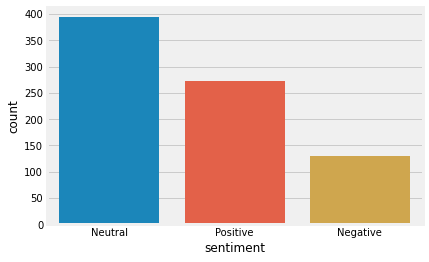

In [55]:
sns.countplot(x='sentiment', data=df_tweet)

**Most frequent words in our tweets dataset**

In [56]:
english_tweets=df_tweet.copy()

In [57]:
# text Preprocessing
english_tweets['cleaned_text'] = english_tweets['cleaned_text'].apply(
    lambda x: clean(x,
                    no_emoji=True,
                    lower=True,
                    no_punct=True,
                    no_line_breaks=True,
                    no_currency_symbols=True))

In [58]:
all_words=' '.join(english_tweets.cleaned_text.values)

In [59]:
wordcloud_obj=WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(all_words)

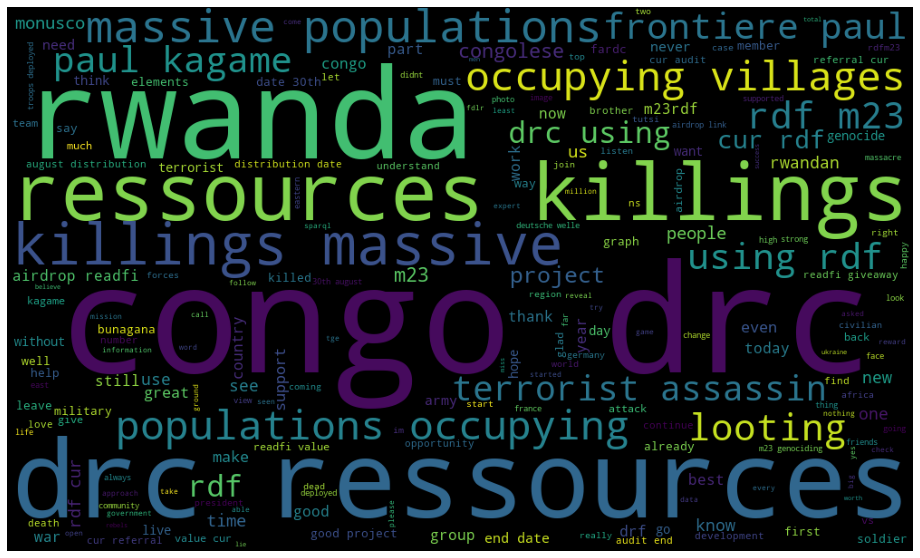

In [60]:
plt.figure(figsize=(20, 10))

fgg=plt.imshow(wordcloud_obj)
plt.axis('off')
# plt.title('Most Frequent Words In Our Tweets',fontsize=16)
plt.show()

In [61]:
# fgg.figure.savefig('plotly_dashboard/cw_rdf.png',bbox_inches='tight',pad_inches=0)
# fgg.figure.savefig('plotly_dashboard/assets/cw_rdf.png',bbox_inches='tight',pad_inches=0)

### Topic modeling

In [62]:
def preprocess_data(tweets_df):
    # Converting tweets to list of words For feature engineering
    sentence_list = [tweet for tweet in tweets_df['cleaned_text']]
    word_list = [sent.split() for sent in sentence_list]
    #Save only words and excludes emojis, punctuations
    word_list_new=[]
    for sent in word_list:
        word_list_new.append([re.split(r'\W+',word) for word in sent if word not in STOPWORDS and not word.isdigit()])
    
    word_list_final=[]
    for sent in word_list_new:
        word_list_final.append([i[0] for i in sent])
    # Create dictionary which contains Id and word 
    word_to_id = corpora.Dictionary(word_list_final)
    corpus_1 = [word_to_id.doc2bow(tweet) for tweet in word_list_final]

    return word_list_final, word_to_id, corpus_1

In [63]:
word_list, id2word, corpus=preprocess_data(english_tweets)

In [64]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [65]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('drc', 0.07807228),
   ('congo', 0.074431635),
   ('ressources', 0.04703328),
   ('killings', 0.045851033),
   ('populations', 0.04290334),
   ('massive', 0.04207937),
   ('villages', 0.041592937),
   ('occupying', 0.0413062),
   ('rwanda', 0.035030253),
   ('rdf', 0.034665264)]),
 (1,
  [('rdf', 0.02610264),
   ('rwanda', 0.009161333),
   ('m23', 0.007864916),
   ('rwandan', 0.0064399242),
   ('congolese', 0.0047694733),
   ('see', 0.0041023265),
   ('killed', 0.0039883754),
   ('monusco', 0.0038606755),
   ('m23rdf', 0.0036709313),
   ('never', 0.0035524776)]),
 (2,
  [('rdf', 0.029156039),
   ('', 0.016725784),
   ('project', 0.0071440833),
   ('good', 0.005292239),
   ('use', 0.004910284),
   ('know', 0.004664946),
   ('time', 0.0044184714),
   ('new', 0.0042332592),
   ('people', 0.004206954),
   ('date', 0.0037170236)])]


### Model Analysis

In [66]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -6.830520343081237

 Ldamodel Coherence Score/Accuracy on Tweets:  0.5342172729106244


**Model 1 words with some digits, 5 topics**

Perplexity:  -9.857909007134007\
Ldamodel Coherence Score/Accuracy on Tweets:  0.4242327533406264

**Model 2 words without digits, 5 topics**

Perplexity:  -9.82031321033761\
Ldamodel Coherence Score/Accuracy on Tweets:  0.4368570452021986

In [67]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.146632  0.120096       1        1  34.016488
0      0.264513  0.009030       2        1  33.382928
1     -0.117880 -0.129126       3        1  32.600585, topic_info=            Term        Freq       Total Category  logprob  loglift
69           drc  303.000000  303.000000  Default  30.0000  30.0000
68         congo  289.000000  289.000000  Default  29.0000  29.0000
77    ressources  183.000000  183.000000  Default  28.0000  28.0000
71      killings  178.000000  178.000000  Default  27.0000  27.0000
76   populations  167.000000  167.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
7            m23   29.837367  164.016452   Topic3  -4.8453  -0.5834
52            us    9.260900   23.280162   Topic3  -6.0153   0.1990
383       people    9.519324   26.396016   Topic3  -5.9878   0.1010
103        great    8.334806   15.534674   Topic3  -6.1207   0.4982
93                  8.010067   74.442883   Topic3  -6.1604  -1.1085

[168 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
93        1  0.886586         
93        3  0.107465         
3145      3  0.931682      ads
1093      3  0.979153   africa
205       1  0.971211  airdrop
...     ...       ...      ...
831       2  0.917473    welle
227       1  0.991757     work
324       3  0.954386    world
27        3  0.975781    years
1524      3  0.922941      yes

[170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

###  END

**Number of Topics optimatization**

As we can see the coherence accuracy increases with number of topics which is expected but again \
many topics again would lead to meaningless conclusion. Let's use elbow method to find optimum number of topics

In [ ]:
# # Find best LDA Model considering different number of topics

# params_dic={'topics_number':[],'coherence':[],'perplexity':[]}
# for top_number in range(1,10):
#     lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                             id2word=id2word,
#                                             num_topics=top_number, 
#                                             random_state=100,
#                                             update_every=1,
#                                             chunksize=100,
#                                             passes=10,
#                                             alpha='auto',
#                                             per_word_topics=False)
    
#     perplexity=lda_model.log_perplexity(corpus)  
#     # Compute Coherence Score
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     params_dic['topics_number'].append(top_number)
#     params_dic['coherence'].append(coherence_lda)
#     params_dic['perplexity'].append(perplexity)

In [ ]:
# pd.DataFrame(params_dic).plot(y=['coherence'])
# # pd.read_csv("elbow_metrics.csv",index_col=0).plot(y=['coherence'])

In [ ]:
# import numpy as np

In [ ]:
# alphas = list(np.arange(0.01, 3, 0.1))
# alphas.append('symmetric')
# alphas.append('asymmetric')
# alphas.append('auto')

In [ ]:
# # Find best LDA Model considering different number of alpha

# params_dic_alpha={'alpha':[],'coherence':[],'perplexity':[]}
# for alpha in alphas:
#     lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                             id2word=id2word,
#                                             num_topics=7, 
#                                             random_state=100,
#                                             update_every=1,
#                                             chunksize=100,
#                                             passes=10,
#                                             alpha=alpha,
#                                             per_word_topics=False)
    
#     perplexity=lda_model.log_perplexity(corpus)  
#     # Compute Coherence Score
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     params_dic_alpha['alpha'].append(alpha)
#     params_dic_alpha['coherence'].append(coherence_lda)
#     params_dic_alpha['perplexity'].append(perplexity)

In [ ]:
# pd.DataFrame(params_dic_alpha).plot(y='coherence')#.sort_values('coherence',ascending=False)

**Model with selected optimum parameters**

In [ ]:
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                            id2word=id2word,
#                                            num_topics=7, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=0.1,
#                                            per_word_topics=False)

In [ ]:
# pprint(lda_model.show_topics(formatted=False))

In [ ]:
# # Compute Perplexity
# #It's a measure of how good the model is. The lower the better. Perplexity is a negative value
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# # doc_lda = lda_model[corpus]

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)

In [ ]:
# # Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
# LDAvis_prepared